In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '.jp-Notebook { padding-left: 0% !important; padding-right: 0% !important; width:100% !important; } '
    '</style>'
))

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

matplotlib.style.use("bmh")
font = {'size': 13}
matplotlib.rc('font', **font)

from IPython.display import display

%load_ext autoreload
%autoreload 2
    
import v0_2_0

/tmp/ipykernel_158363/2699245673.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
COLLECT_TS = "2024-08-04T18:01:53.300127572+00:00"
TARGET_PID = "633743"
TARGET_METRIC = "throughput(events/s)"
PATH = "figures/kafka"
FIGSIZE=(3.2, 3)
os.makedirs(PATH, exist_ok=True)

# Target

In [4]:
target = pd.read_csv(f"../data/{COLLECT_TS}/application-metrics/target.csv")
target["epoch_s"] = target["epoch_ms"] // 1_000
target["throughput(events/s)"] = target["total_events"].diff() / target["epoch_s"].diff()
MIN_TIMESTAMP, MAX_TIMESTAMP = target["epoch_s"].min(), target["epoch_s"].max()

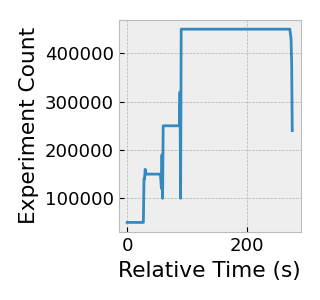

In [5]:
plt.figure(figsize=FIGSIZE)
plt.plot(target["epoch_s"] - MIN_TIMESTAMP, target["experiment_count"] * 10_000)
plt.xlabel("Relative Time (s)")
plt.ylabel("Experiment Count")
plt.tight_layout()
plt.savefig(f"{PATH}/experiment_count.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

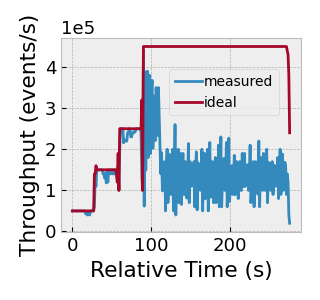

In [6]:
plt.figure(figsize=FIGSIZE)
plt.plot(target["epoch_s"] - MIN_TIMESTAMP, target["throughput(events/s)"], label="measured")
plt.plot(target["epoch_s"] - MIN_TIMESTAMP, target["experiment_count"] * 10_000, label="ideal")
plt.xlabel("Relative Time (s)")
plt.ylabel("Throughput (events/s)")
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()
plt.legend(loc=(0.45, 0.6), prop={"size": 10}, handletextpad=0.1, columnspacing=0.5)
plt.savefig(f"{PATH}/throughput.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Scheduler

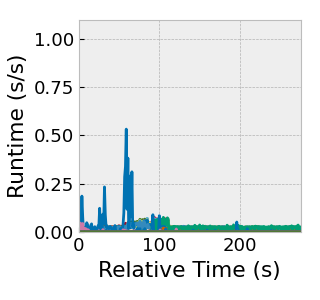

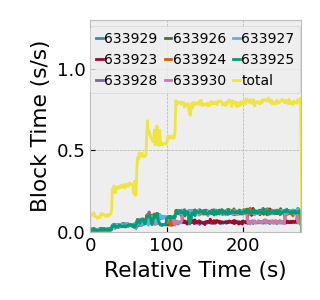

In [40]:
XLIM, YLIM = [0, MAX_TIMESTAMP - MIN_TIMESTAMP], [0, 1.1]
START_TIMESTAMP = MIN_TIMESTAMP + XLIM[0]
END_TIMESTAMP = MIN_TIMESTAMP + XLIM[1]

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))

plt.close('all')

# Sched Runtime

col_filter = metrics.columns[metrics.columns.str.contains("runtime_rate")].append(pd.Index(["epoch_s"]))
sched = metrics.loc[:, col_filter]
sched = pd.merge(sched, target.loc[:, ["epoch_s", TARGET_METRIC]], on="epoch_s", how="outer")
sched = sched.loc[(sched["epoch_s"] > START_TIMESTAMP) & (sched["epoch_s"] < END_TIMESTAMP), :]
corr = sched.corr()[TARGET_METRIC]
corr = corr.sort_values(ascending=False)
significant_corr = corr # [(corr > 0.5) | (corr < -0.5)]

plt.figure(figsize=FIGSIZE)
plt.ylabel("Runtime (s/s)")
plt.xlabel("Relative Time (s)")
threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or TARGET_METRIC in col or "epoch_ms" in col: 
        continue
    threads = threads.append(pd.Index([col]))
    thread = re.sub(r"thread/\d+/(\d+)/.*", r"\1", col)
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=thread)
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.tight_layout()
plt.savefig(f"{PATH}/runtime.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

runtime_threads = threads

# Sched iowait

# col_filter = metrics.columns[metrics.columns.str.contains("iowait_time_rate")].append(pd.Index(["epoch_s"]))
# sched = metrics.loc[:, col_filter]
# sched = pd.merge(sched, target.loc[:, ["epoch_s", TARGET_METRIC]], on="epoch_s", how="outer")
# sched = sched.loc[(sched["epoch_s"] > START_TIMESTAMP) & (sched["epoch_s"] < END_TIMESTAMP), :]
# corr = sched.corr()[TARGET_METRIC]
# corr = corr.sort_values(ascending=False)
# significant_corr = corr # [(corr > 0.5) | (corr < -0.5)]

# plt.figure(figsize=(8, 4))
# plt.title("Time in IO Wait")
# plt.xlabel("relative time (s)")
# threads = pd.Index([])
# res = pd.Series(dtype="Float64")
# for col in significant_corr.index: 
#     if "epoch_s" in col or TARGET_METRIC in col or "epoch_ms" in col: 
#         continue
#     if metrics[col].median() < 0.02:
#         continue
#     threads = threads.append(pd.Index([col]))
#     sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
#     sub.columns = ["value"]
#     res = res.add(sub, fill_value=0)
#     threads = threads.append(pd.Index([col]))
#     thread = re.sub(r"thread/\d+/(\d+)/.*", r"\1", col)
#     plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=thread)
# res = res.reset_index()
# plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"], label="total")
# plt.xlim(XLIM)
# plt.ylim(YLIM)
# plt.legend()
# plt.show()

# iowait_threads = threads

# Sched Block

col_filter = metrics.columns[metrics.columns.str.contains("block_time_rate")].append(pd.Index(["epoch_s"]))
sched = metrics.loc[:, col_filter]
sched = pd.merge(sched, target.loc[:, ["epoch_s", TARGET_METRIC]], on="epoch_s", how="outer")
sched = sched.loc[(sched["epoch_s"] > START_TIMESTAMP) & (sched["epoch_s"] < END_TIMESTAMP), :]
corr = sched.corr()[TARGET_METRIC]
corr = corr.sort_values(ascending=False)
significant_corr = corr # [(corr > 0.5) | (corr < -0.5)]

plt.figure(figsize=FIGSIZE)
plt.ylabel("Block Time (s/s)")
plt.xlabel("Relative Time (s)")
threads = pd.Index([])
res = pd.Series(dtype="Float64")
for col in significant_corr.index: 
    if "epoch_s" in col or TARGET_METRIC in col or "epoch_ms" in col: 
        continue
    if metrics[col].median() < 0.05:
        continue
    threads = threads.append(pd.Index([col]))
    sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
    sub.columns = ["value"]
    res = res.add(sub, fill_value=0)
    thread = re.sub(r"thread/\d+/(\d+)/.*", r"\1", col)
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=thread)
res = res.reset_index()
plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"], label="total")
plt.xlim(XLIM)
plt.ylim([0, 1.3])
plt.legend(loc="upper center", ncol=3, prop={"size": 10}, handletextpad=0.1, columnspacing=0.5, handlelength=0.5)
plt.tight_layout()
plt.savefig(f"{PATH}/block_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

block_threads = threads

# Sched Runqueue

# col_filter = metrics.columns[metrics.columns.str.contains("rq_time_rate")].append(pd.Index(["epoch_s"]))
# sched = metrics.loc[:, col_filter]
# sched = pd.merge(sched, target.loc[:, ["epoch_s", TARGET_METRIC]], on="epoch_s", how="outer")
# sched = sched.loc[(sched["epoch_s"] > START_TIMESTAMP) & (sched["epoch_s"] < END_TIMESTAMP), :]
# corr = sched.corr()[TARGET_METRIC]
# corr = corr.sort_values(ascending=False)
# significant_corr = corr# [(corr > 0.5) | (corr < -0.5)]

# plt.figure(figsize=(8, 4))
# plt.title("Time Waiting in Run Queue")
# plt.xlabel("relative time (s)")
# threads = pd.Index([])
# for col in significant_corr.index: 
#     if "epoch_s" in col or TARGET_METRIC in col or "epoch_ms" in col: 
#         continue
#     threads = threads.append(pd.Index([col]))
#     plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
# plt.xlim(XLIM)
# plt.ylim(YLIM)
# plt.show()

# rq_threads = threads

**Observations**

1. There is runtime activity precisely at the moments the number of experiments increases. (633873 C2 CompilerThre)
2. There is significant activity in block + iowait time. Additionally there is only a subset of threads that participate in this activity, these being threads 633923-633930 (data-plane-kafk).

# Futex

From the previous section, we can observe there is block activity in threads 633923-633930. However, most of their time is spent sleeping. For this reason, we will now analyse how these threads are sleeping on their futex resources.

## Wait

After filtering the threads to include only the ones that present interesting block activity, we then only plot the futex resources used by these threads that are also interesting. It is important to note that we keep track of all interesting futex addresses in a  Python `set`

633743-0x74237994a778
633743-0x74237994a77c


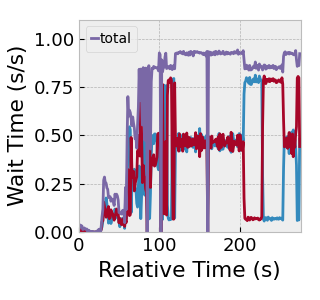

In [15]:
import re

# 633865 G1 Conc#0
# 633864 G1 Main Marker
# 633928 data-plane-kafk
# 633925 data-plane-kafk
# 633930 data-plane-kafk
# 633927 data-plane-kafk
# 633926 data-plane-kafk
# 633923 data-plane-kafk
# 633924 data-plane-kafk
# 633929 data-plane-kafk

XLIM = [0, MAX_TIMESTAMP - MIN_TIMESTAMP]

START_TIMESTAMP = MIN_TIMESTAMP 
END_TIMESTAMP = MIN_TIMESTAMP + 200

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))

plt.close('all')

threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
futex_threads = set()
futex_address = set()
for thread in range(633923, 633931, 1):
    if thread != 633923:
        continue
    plt.figure(figsize=FIGSIZE)
    plt.ylabel("Wait Time (s/s)")
    plt.xlabel("Relative Time (s)")

    files = metric_files[metric_files.str.contains(f"{TARGET_PID}/{thread}/")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_wait_rate")].append(pd.Index(["epoch_s"]))
    metrics = metrics.loc[:, futex_wait_filter]
    metrics = pd.merge(metrics, target.loc[:, ["epoch_s", TARGET_METRIC]], on="epoch_s", how="outer")
    metrics = metrics.loc[(metrics["epoch_s"] > MIN_TIMESTAMP) & (metrics["epoch_s"] < MAX_TIMESTAMP), :]
    
    corr = metrics.corr()[TARGET_METRIC]
    corr = corr.sort_values(ascending=False)
    # corr = corr[(corr > 0.2) | (corr < -0.2)]

    res = pd.Series(dtype="Float64")
    res.name = "value"
    for col in corr.index:
        if "epoch_s" in col or TARGET_METRIC in col: 
            continue
        if metrics[col].median() < 0.1: 
            continue
        futex = re.sub(r".*/wait/(.*?)/.*", r"\1", col)
        print(futex)
        futex_threads.add(thread)
        futex_address.add(futex)
        sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
        sub.columns = ["value"]
        res = res.add(sub["value"], fill_value=0)
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
    res = res.reset_index()
    plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"], label="total")
    plt.legend(loc="upper left", prop={"size": 10}, handletextpad=0.1, columnspacing=0.5, handlelength=0.5)
    plt.xlim(XLIM)
    plt.ylim([0, 1.1])
    plt.tight_layout()
    plt.savefig(f"{PATH}/futex_wait_time.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

**Observations**

1. Each thread is waiting on an exclusive set of futex resources.
2. There are clear changepoints around the same time as the target metric is degraded.

## Wake

Given the set of interesting futexes, we now determine which futex resources a particular thread is waking.

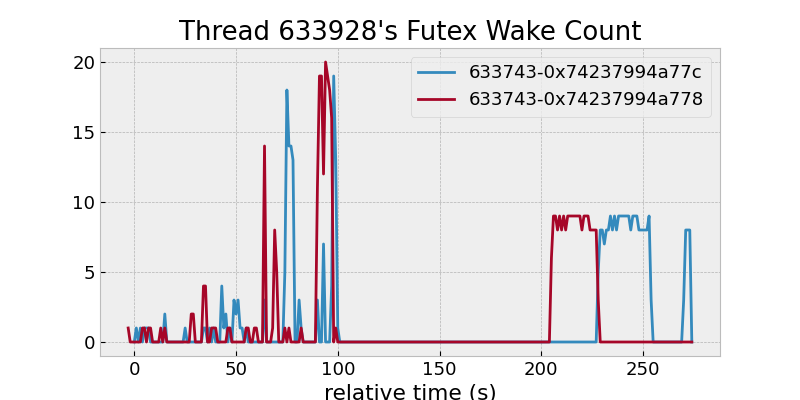

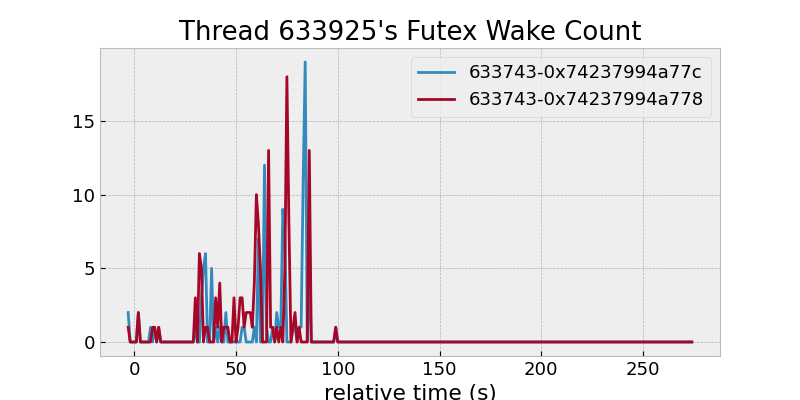

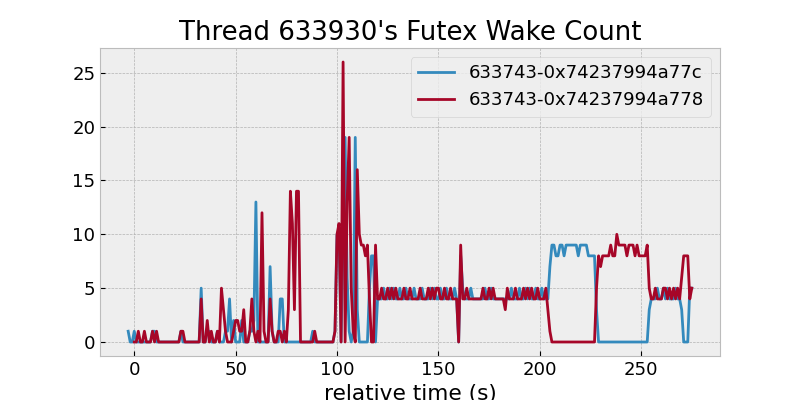

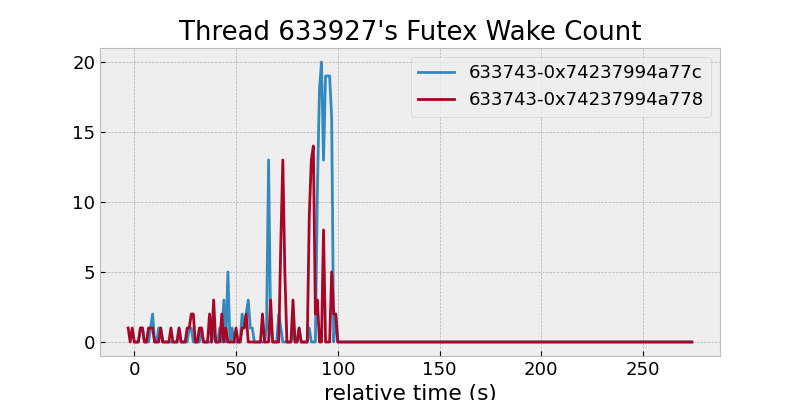

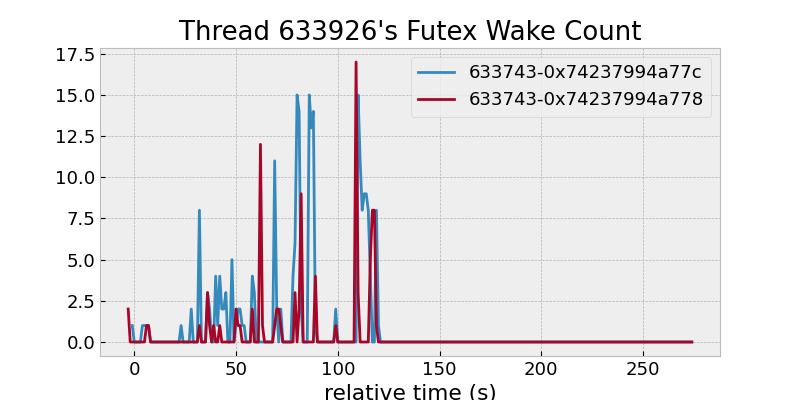

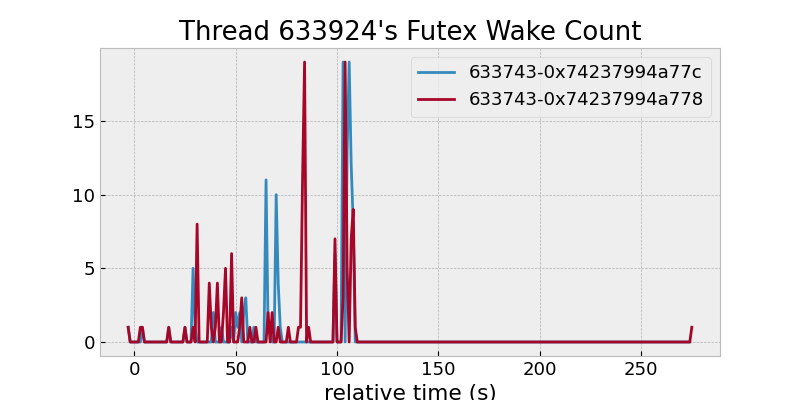

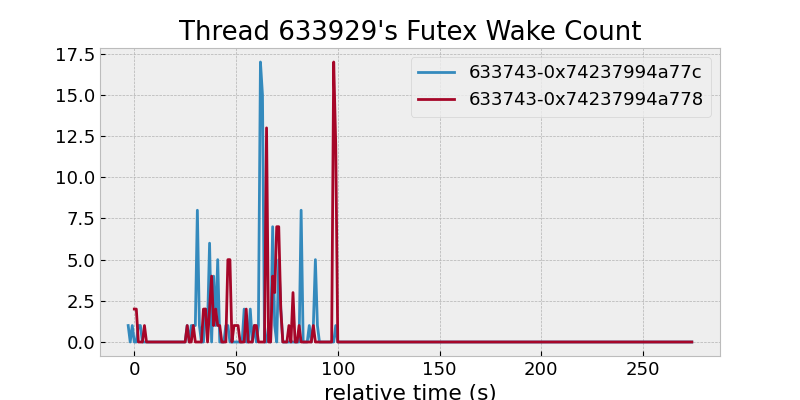

In [50]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

plt.close('all')

threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
wake_threads = set()
for thread in threads:
    files = metric_files[metric_files.str.contains(f"{TARGET_PID}/{thread}/")]
    if not files.str.contains("|".join(futex_address)).any():
        continue
    plt.figure(figsize=(8, 4))
    plt.title(f"Thread {thread}'s Futex Wake Count")
    plt.xlabel("relative time (s)")
    for futex in futex_address:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_count")]
        for col in futex_wait_filter:
            wake_threads.add(f"{thread}/{futex}")
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{futex}")
    # plt.xlim()
    plt.legend()
    plt.show()

**Observations**

Interstingly, other than a few exceptions (thread's 633948 "data-plane-kafk", 633942 "kafka-scheduler"), the thread that waits for a specific futex does not wake up other threads on the same futex. What can be said about these futexes then is that they probably function as a work signal. 

The threads that were signalled as having interesting block and futex signals, are the same threads that are waking each other's futex resources. Furthermore, these same threads all share the same `comm` identifier, which strongly suggests these threads work as a thread pool to perform certain tasks.

Another observation is that the total time spent waiting for the interesting futexes, at times increases. It might be interesting to have a look at these thread's scheduling times to determine whether this has an impact on any of its times.

Conversely, we will now plot the threads that are waking each futex resource. I.e., each plot will contain the number of times a particular futex resource was awakened by each thread.

633743-0x74237994a778


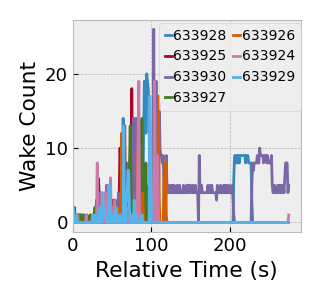

633743-0x74237994a77c


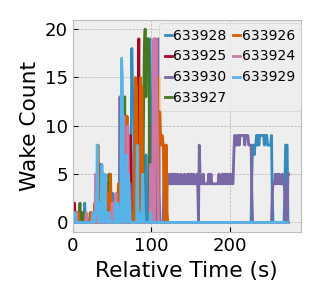

In [17]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

plt.close('all')

for futex in futex_address:
    # if futex != "633743-0x74237994a778":
    #     continue
    files = metric_files[metric_files.str.contains(f"{futex}")]
    print(futex)
    plt.figure(figsize=FIGSIZE)
    plt.ylabel("Wake Count")
    plt.xlabel("Relative Time (s)")
    threads = files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
    
    res = pd.Series(dtype="Float64")
    res.name = "value"
    for thread in threads:
        thread_files = files[files.str.contains(f"/{TARGET_PID}/{thread}/")]
        metrics = v0_2_0.metric_files_to_df(thread_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        col_filter = metrics.columns[metrics.columns.str.contains("futex_count")]
        for col in col_filter:
            sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
            sub.columns = ["value"]
            res = res.add(sub["value"], fill_value=0)            
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}")
    plt.xlim([0, 290])
    # res = res.reset_index()
    # plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"], label="total")
    plt.legend(loc=(0.38, 0.57), ncol=2, prop={"size": 10}, handletextpad=0.1, columnspacing=0.5, handlelength=0.5)
    plt.tight_layout()
    plt.savefig(f"{PATH}/futex_wake_count.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

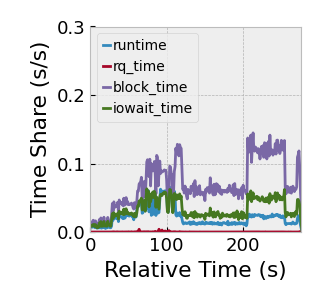

In [62]:
XLIM, YLIM = [0, MAX_TIMESTAMP-MIN_TIMESTAMP], [0, 1.5]
START_TIMESTAMP = MIN_TIMESTAMP + XLIM[0]
END_TIMESTAMP = MIN_TIMESTAMP + XLIM[1]

plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))

for thread in range(633923, 633931, 1):
    if thread != 633923: 
        continue
    plt.figure(figsize=FIGSIZE)
    plt.ylabel("Time Share (s/s)")
    plt.xlabel("Relative Time (s)")
    files = metric_files[metric_files.str.contains(f"{TARGET_PID}/{thread}")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    rate_filter = metrics.columns[metrics.columns.str.contains("_rate")].append(pd.Index(["epoch_s"])).drop(f"thread/{TARGET_PID}/{thread}/sched/sleep_time_rate")
    metrics = metrics.loc[:, rate_filter]
    for col in metrics.columns:
        if col == "epoch_s": 
            continue
        sched_metric = re.search(r"/(\w+?)_rate$", col).groups()[0]
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=sched_metric)
    plt.legend(loc="upper left", prop={"size": 10}, handletextpad=0.2, columnspacing=0.5, handlelength=0.5)
    plt.xlim(0, MAX_TIMESTAMP - MIN_TIMESTAMP)
    plt.ylim([0, 0.3])
    plt.tight_layout()
    plt.savefig(f"{PATH}/sched_activity_633923.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

**Observations**

As can be seen in threads 633923 and 633930, the time the thread spends in a blocked state dips at the same time the total futex wait time for each thread increases.

# IPC

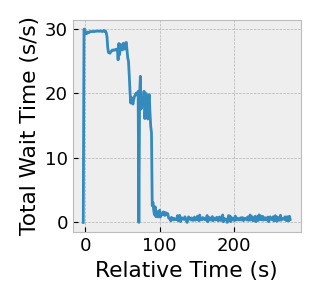

In [96]:
HOST = "172.26.0.1"

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/global/epoll")
metric_files = pd.Series(filter(lambda s: HOST in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
col_filter = metrics.columns[metrics.columns.str.contains("wait_rate")]
metrics = metrics.loc[:, col_filter.append(pd.Index(["epoch_s"]))]

plt.close("all")

epolls = metrics.columns.str.replace(r".*/epoll/(.*?)/.*", r"\1", regex=True).unique()
epolls = epolls[epolls != "epoch_s"]

for epoll in epolls:
    if epoll != "ffff9a7a3f5e1740":
        continue
    plt.figure(figsize=FIGSIZE)
    plt.ylabel("Total Wait Time (s/s)")
    plt.xlabel("Relative Time (s)")
    col_filter = metrics.columns[metrics.columns.str.contains(f"{epoll}")]
    res = pd.Series(dtype="Float64")
    res.name = "value"
    for col in col_filter:

        sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
        sub.columns = ["value"]
        res = res.add(sub["value"], fill_value=0)
        # plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
    res = res.reset_index()
    plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"], label="total")
    plt.tight_layout()
    plt.savefig(f"{PATH}/total_external_wait_time.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

thread/633743/633948/ipc/streams/epoll_ffff9a7a3f5e1740/stream_wait_rate


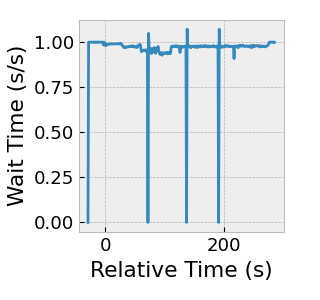

In [95]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'epoll' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
col_filter = metrics.columns[metrics.columns.str.contains("ffff9a7a3f5e0300|ffff9a7a3f5e1740|ffff9a7a3f5e1bc0")]
col_filter = col_filter[col_filter.str.contains("_rate")]
metrics = metrics.loc[:, col_filter.append(pd.Index(["epoch_s"]))]

plt.figure(figsize=FIGSIZE)
plt.ylabel("Wait Time (s/s)")
plt.xlabel("Relative Time (s)")
for col in metrics.columns:
    if (col == "epoch_s") or ("ffff9a7a3f5e1740" not in col):
        continue
    print(col)
    label = re.sub(r".*/(.*?)/ipc/streams/epoll_(.*)/.*", r"\1/\2", col)
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=label)
# plt.legend()
plt.tight_layout()
plt.savefig(f"{PATH}/epoll_wait_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

**Observations**

1. 3 epoll resources are used to multiplex the IO between all connections to the load generation host
2. The are clear changepoints at around the same time instances as the target metric degrades.
3. During the degradation of the target metric, the combined wait time of all connections is below 1s.
4. The threads waiting for the epoll resources are consistently waiting for their epoll instances close to 100% of their time. Therefore, we cannot say that the time spent waiting for external hosts is the cause of the problem.

# Request to Disk Trace

array(['ffff9a7a3f5e1bc0'], dtype=object)

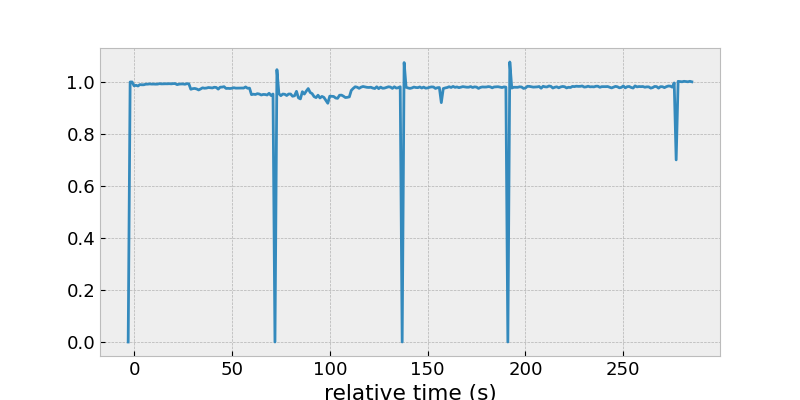

In [97]:
plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/global/epoll/ffff9a7a3f5e1bc0")
metric_files = pd.Series(filter(lambda s: '14_' in s, metric_files))
epolls = metric_files.str.replace(r".*global/epoll/(\w+)/.*", r"\1", regex=True).unique()

display(epolls)

res = pd.Series(dtype="Float64")
for epoll in epolls:
    files = metric_files[metric_files.str.contains(f"/{epoll}/")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
    swr_filter = metrics.columns[metrics.columns.str.contains("stream_wait_rate")]
    sub = metrics.loc[:, swr_filter.append(pd.Index(["epoch_s"]))]
    long = sub.melt(id_vars=["epoch_s"], value_vars=swr_filter)
    res = res.add(long.groupby(["epoch_s"])["value"].sum(), fill_value=0)

plt.figure(figsize=(8, 4))
plt.xlabel("relative time (s)")
plt.plot(res.index - MIN_TIMESTAMP, res)
plt.show()

thread/633743/633928/ipc/streams/14_2159682/count
thread/633743/633925/ipc/streams/14_2159682/count
thread/633743/633930/ipc/streams/14_2159682/count
thread/633743/633927/ipc/streams/14_2159682/count
thread/633743/633926/ipc/streams/14_2159682/count
thread/633743/633923/ipc/streams/14_2159682/count
thread/633743/633924/ipc/streams/14_2159682/count
thread/633743/633929/ipc/streams/14_2159682/count


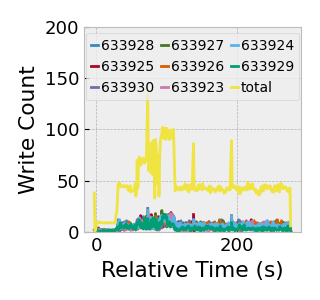

In [8]:
plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: '14_2159682' in s, metric_files))
threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()

plt.figure(figsize=FIGSIZE)
plt.ylabel("Write Count")
plt.xlabel("Relative Time (s)")
res = pd.Series(dtype="Float64")
res.name = "value"
ncol = 0
for thread in threads:
    if thread not in ['633928', '633925', '633930', '633927', '633926', '633923', '633924', '633929']:
        continue
    files = metric_files[metric_files.str.contains(f"/{thread}/")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
    swr_filter = metrics.columns[metrics.columns.str.contains("count")]
    for col in swr_filter:
        sub = metrics.loc[:, [col, "epoch_s"]]
        sub = sub.set_index("epoch_s")
        sub.columns = ["value"] 
        res = res.add(sub["value"], fill_value=0)
        thread, = re.search(r"thread/\d+/(\d+)/", col).groups()
        print(col)
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=thread)
        ncol += 1
    # sub = metrics.loc[:, swr_filter.append(pd.Index(["epoch_s"]))]
    # long = sub.melt(id_vars=["epoch_s"], value_vars=swr_filter)
    # res = res.add(long.groupby([
res = res.reset_index().dropna()
plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"], label="total")
ncol += 1
plt.legend(ncol=3, loc="upper center", prop={"size": 10}, handletextpad=0.2, columnspacing=0.5, handlelength=0.5)
plt.ylim([0, 200])
plt.tight_layout()
plt.savefig(f"{PATH}/pipe_write_count.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# res = pd.Series(dtype="Float64")
# for epoll in epolls:
#     files = metric_files[metric_files.str.contains(f"/{epoll}/")]
#     metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
#     swr_filter = metrics.columns[metrics.columns.str.contains("stream_wait_rate")]
#     sub = metrics.loc[:, swr_filter.append(pd.Index(["epoch_s"]))]
#     long = sub.melt(id_vars=["epoch_s"], value_vars=swr_filter)
#     res = res.add(long.groupby(["epoch_s"])["value"].sum(), fill_value=0)

# plt.figure(figsize=(8, 4))
# plt.title("Combined wait time for 172.22.0.1")
# plt.xlabel("relative time (s)")
# plt.plot(res.index - MIN_TIMESTAMP, res)
# plt.show()